In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict
from itertools import product
from random import choices
import io
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set(style="whitegrid", font="serif", font_scale=1)

In [4]:
words_collection = {}
with open('./wordsapi_sample.json', 'r') as input_json:
    words_collection = json.load(input_json)

In [5]:
len(words_collection)

32427

In [6]:
words_collection_defined = {k: v for k, v in words_collection.items() if 'definitions' in v}

In [7]:
len(words_collection_defined)

14659

In [8]:
with_sinonims = defaultdict(int)
with_antonims = defaultdict(int)
for word, data in words_collection_defined.items():
    for definition in data['definitions']:
        if 'synonyms' in definition:
            with_sinonims[word] += 1
        if 'antonyms' in definition:
            with_antonims[word] += 1


In [9]:
len(with_sinonims), len(with_antonims)

(10959, 656)

In [10]:
pairs = []
for w in with_antonims:
    antonyms_pairs_for_word = []
    synonims_pairs_for_word = []
    data = words_collection_defined[w]
    for definition in data['definitions']:
        synonyms = definition['synonyms'] + [w] if 'synonyms' in definition else [w]
        antonyms = definition['antonyms'] if 'antonyms' in definition else []
        antonyms_pairs = set(product(synonyms, antonyms))
        synonyms_pairs = set(product(synonyms, synonyms))
        antonyms_pairs = set([tuple(sorted([fst, scnd])) for fst, scnd in antonyms_pairs if fst != scnd])
        synonyms_pairs = set([tuple(sorted([fst, scnd])) for fst, scnd in synonyms_pairs if fst != scnd])
        antonyms_pairs_for_word.extend(antonyms_pairs)
        synonims_pairs_for_word.extend(synonyms_pairs)
    pairs.append(
        {
            'synonymic': synonims_pairs_for_word,
            'antonymic': antonyms_pairs_for_word
        }
    )
    

In [11]:
len(pairs)

656

In [12]:
antonymic_pair_sizes = [len(pair['antonymic']) for pair in pairs] 

In [13]:
sum(antonymic_pair_sizes)

1272

In [14]:
synonymic_pair_sizes = [len(pair['synonymic']) for pair in pairs]

In [15]:
sum(synonymic_pair_sizes)

5074

In [16]:
test = []
for pair in pairs:
    syn, ant = pair['synonymic'], pair['antonymic']
    for p in syn:
        test.append((*p, '+'))
    for p in ant:
        test.append((*p, '-'))
    

In [17]:
len([t for t, _, sign in test if sign == '-'])

1272

In [18]:
len([t for t, _, sign in test if sign == '+'])

5074

In [19]:
with open('test.json', 'w') as outfile:
    json.dump(test, outfile)

In [20]:
words_in_pair = set()
for fst, scnd, _ in test:
    words_in_pair.add(fst)
    words_in_pair.add(scnd)

In [21]:
vectorized = {}

with open('./wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
    next(fin)
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in words_in_pair:
            vectorized[tokens[0]] = list(map(float, tokens[1:]))


In [22]:
len(vectorized)

2404

In [23]:
len(words_in_pair)

3038

In [39]:
cleared_pairs = []
for fst, scnd, sign in test:
    if fst in vectorized and scnd in vectorized:
        cleared_pairs.append((fst, scnd, sign))
cleared_pairs = list(set(cleared_pairs))

In [45]:
len([1 for _, _, sgn in cleared_pairs if sgn == '-'])

786

In [75]:
len(cleared_pairs)

3957

In [76]:
vectors_data = []
for fst, scnd, sign in cleared_pairs:
    if fst in vectorized and scnd in vectorized:
        fst = np.array(vectorized[fst])
        scnd = np.array(vectorized[scnd])
        vectors_data.append((fst, scnd, sign))

In [77]:
signs = np.array([sgn for _, _, sgn in vectors_data])
sq_dif = np.array([np.square(fst - scnd) for fst, scnd, _ in vectors_data])

In [78]:
sq_dif.shape

(3957, 300)

In [49]:
pca = PCA(n_components=2)
pca.fit(sq_dif.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
new_sq_data = pca.components_

In [51]:
formated_data = pd.DataFrame(
    {
        'PCA1': new_sq_data[0], 
        'PCA2': new_sq_data[1],
        'type': signs
    }
)

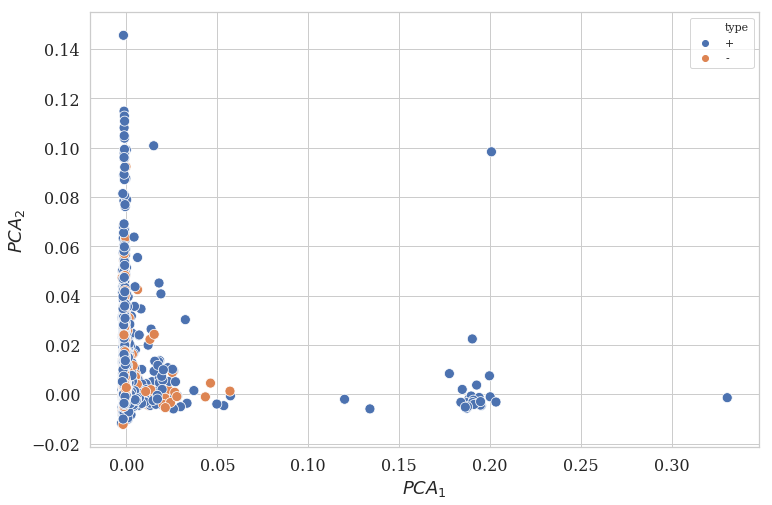

In [61]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x="PCA1", 
    y="PCA2", 
    hue='type', 
    s=100,
    data=formated_data)
plt.xlabel(r'$PCA_1$', size=18)
plt.ylabel(r'$PCA_2$', size=18)
ax.tick_params(labelsize=16)
plt.show()

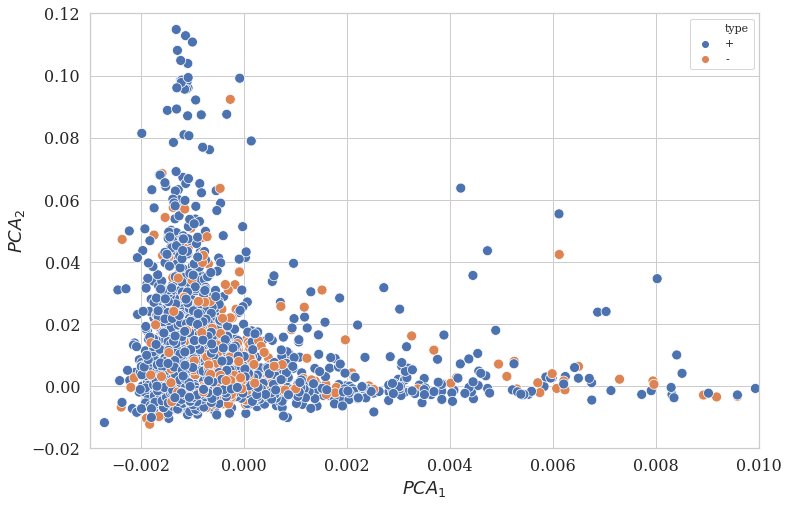

In [60]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x="PCA1", 
    y="PCA2", 
    hue='type', 
    s=100,
    data=formated_data
)
plt.xlabel(r'$PCA_1$', size=18)
plt.ylabel(r'$PCA_2$', size=18)
ax.set(xlim=(-0.003, 0.01))
ax.set(ylim=(-0.02, 0.12))
ax.tick_params(labelsize=16)
plt.show()

In [63]:
X_embedded = TSNE(n_components=2).fit_transform(sq_dif)

In [64]:
formated_data_tsne = pd.DataFrame(
    {
        'x1': X_embedded.T[0], 
        'x2': X_embedded.T[1],
        'type': signs
    }
)

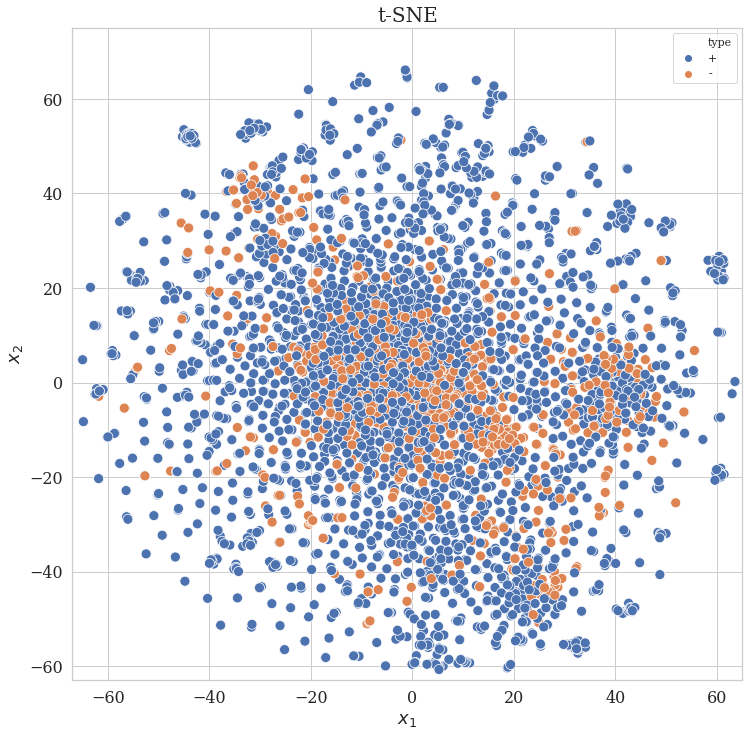

In [70]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(
    x="x1", 
    y="x2", 
    hue='type', 
    s=100,
    data=formated_data_tsne)
plt.xlabel(r'$x_1$', size=18)
plt.ylabel(r'$x_2$', size=18)
plt.title('t-SNE', size=20)
ax.tick_params(labelsize=16)
ax.set(xlim=(-67, 65))
ax.set(ylim=(-63, 75))
plt.show()

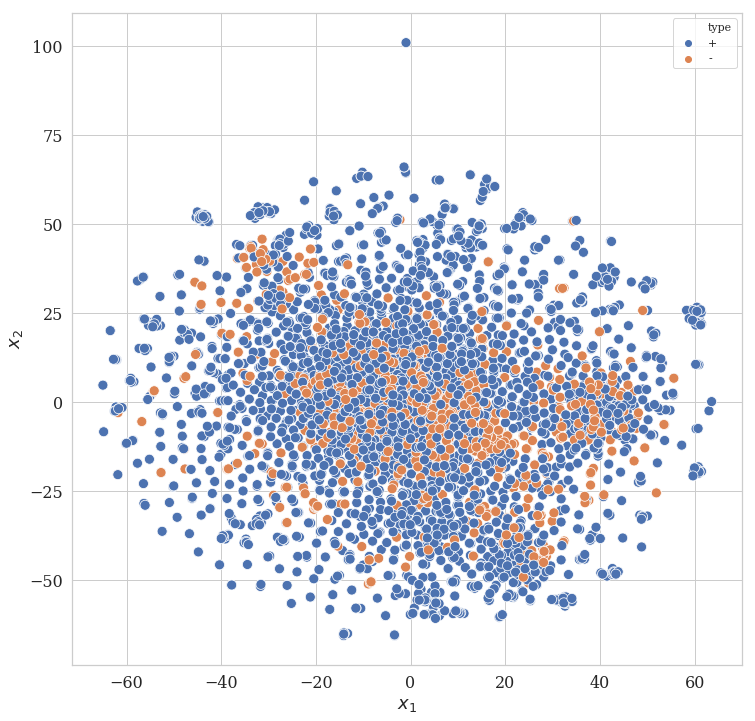

In [71]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(
    x="x1", 
    y="x2", 
    hue='type', 
    s=100,
    data=formated_data_tsne)
plt.xlabel(r'$x_1$', size=18)
plt.ylabel(r'$x_2$', size=18)
ax.tick_params(labelsize=16)
plt.show()

In [79]:
is_ass = np.array(['keister' in p for p in cleared_pairs])

In [80]:
formated_data_tsne_ass = pd.DataFrame(
    {
        'x_1': X_embedded.T[0], 
        'x_2': X_embedded.T[1],
        'type': signs,
        'ass': is_ass
    }
)

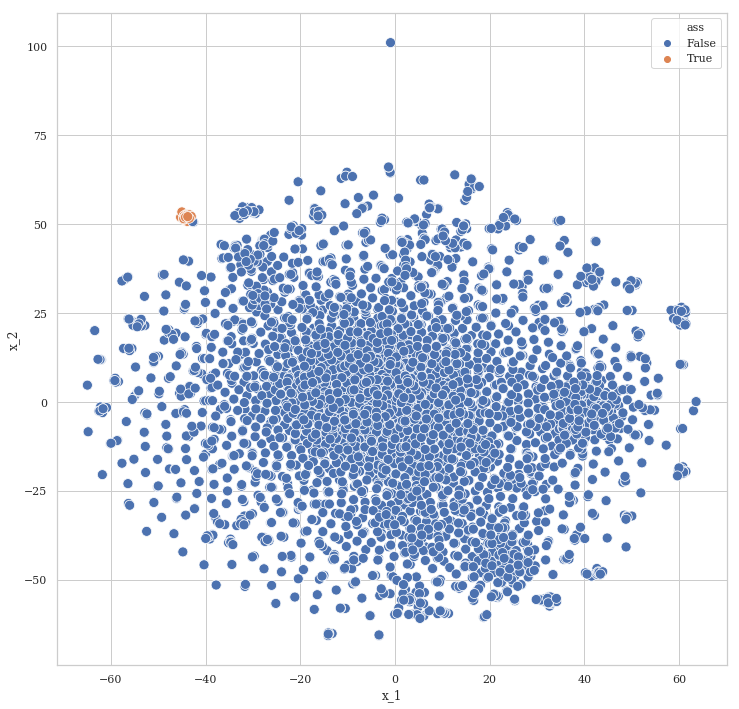

In [81]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(
    x="x_1", 
    y="x_2", 
    hue='ass', 
    s=100,
    data=formated_data_tsne_ass)

## Split by train and test

In [72]:
np.sum(signs == '-') / np.sum(signs == '+')

0.2478713339640492

In [73]:
1000 / len(cleared_pairs)

0.25271670457417234

In [74]:
amount = 0
for elem in pairs:
    amount += len(elem['synonymic'])
    amount += len(elem['antonymic'])
amount
    

6346

In [82]:
test_dataset, train_dataset = [], []

In [83]:
for elem in pairs:
    syn = elem['synonymic']
    ant = elem['antonymic']
    if (len(test_dataset) / amount) < 0.23:
        for fst, scnd in syn:
            test_dataset.append((fst, scnd, '+'))
        for fst, scnd in ant:
            test_dataset.append((fst, scnd, '-'))
    else:
        for fst, scnd in syn:
            train_dataset.append((fst, scnd, '+'))
        for fst, scnd in ant:
            train_dataset.append((fst, scnd, '-'))

In [84]:
len(test_dataset), len(train_dataset)

(1466, 4880)

In [138]:
cleared_test_pairs = list(
    set(
        [
            (f, s, sign) for f, s, sign in test_dataset 
            if (f in vectorized) and (s in vectorized) and (f != s)
        ]
    )
)
cleared_train_pairs = list(
    set(
        [
            (f, s, sign) for f, s, sign in train_dataset 
            if (f in vectorized) and (s in vectorized) and (f != s)
        ]
    )
)

In [139]:
len(cleared_test_pairs)

1024

In [140]:
len(cleared_train_pairs)

2984

In [126]:
with open('test_dataset_clear.json', 'w') as outfile:
    json.dump(cleared_test_pairs, outfile)

In [141]:
len(set(cleared_train_pairs)), len(cleared_train_pairs)

(2984, 2984)

In [90]:
len([1 for _, _, s in cleared_test_pairs if s == '-']) / len([1 for _, _, s in cleared_test_pairs if s == '+'])

0.2848180677540778

In [91]:
len([1 for _, _, s in cleared_train_pairs if s == '-']) / len([1 for _, _, s in cleared_train_pairs if s == '+'])

0.23920265780730898

In [97]:
vec_test = []
for a, b, c in cleared_test_pairs:
    vec_test.append((vectorized[a], vectorized[b], c))

In [99]:
vec_train = []
for a, b, c in cleared_train_pairs:
    vec_train.append((vectorized[a], vectorized[b], c))

In [100]:
len(vec_test)

1024

In [101]:
len(vec_train)

2984

In [109]:
def plot_pca(pairs: list, word_to_array: Dict[str, list]) -> None:
    signs = np.array([s for _, _, s in pairs])
    vectors_data = [
        (np.array(word_to_array[fst]), np.array(word_to_array[scnd])) for fst, scnd, _ in pairs
    ]
    sq_dif = np.array([np.square(fst - scnd) for fst, scnd in vectors_data])
    pca = PCA(n_components=2)
    pca.fit(sq_dif.T)
    new_sq_data = pca.components_
    formated_data = pd.DataFrame(
        {
            'PCA1': new_sq_data[0], 
            'PCA2': new_sq_data[1],
            'type': signs
        }
    )
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="PCA1", 
        y="PCA2", 
        hue='type', 
        s=100,
        data=formated_data)
    plt.xlabel(r'$PCA_1$', size=18)
    plt.ylabel(r'$PCA_2$', size=18)
    ax.tick_params(labelsize=16)
    plt.show()

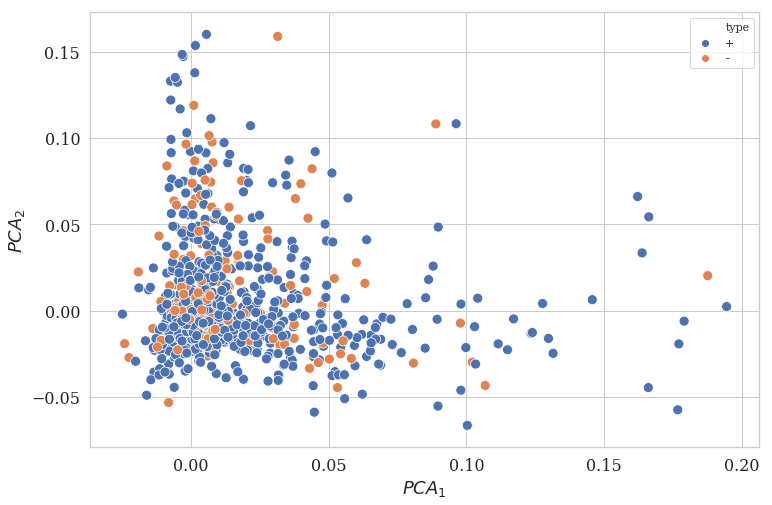

In [110]:
plot_pca(cleared_test_pairs, vectorized)

In [107]:
from typing import Dict

In [120]:
def plot_tsne(pairs: list, word_to_array: Dict[str, list]) -> None:
    signs = np.array([s for _, _, s in pairs])
    vectors_data = [
        (np.array(word_to_array[fst]), np.array(word_to_array[scnd])) for fst, scnd, _ in pairs
    ]
    sq_dif = np.array([np.square(fst - scnd) for fst, scnd in vectors_data])
    X_embedded = TSNE(n_components=2).fit_transform(sq_dif)
    new_sq_data = pca.components_
    formated_data_tsne = pd.DataFrame(
        {
            'x1': X_embedded.T[0], 
            'x2': X_embedded.T[1],
            'type': signs
        }
    )
    plt.figure(figsize=(12, 12))
    ax = sns.scatterplot(
        x="x1", 
        y="x2", 
        hue='type', 
        s=100,
        data=formated_data_tsne)
    plt.xlabel(r'$x_1$', size=18)
    plt.ylabel(r'$x_2$', size=18)
    ax.tick_params(labelsize=16)
    plt.show()

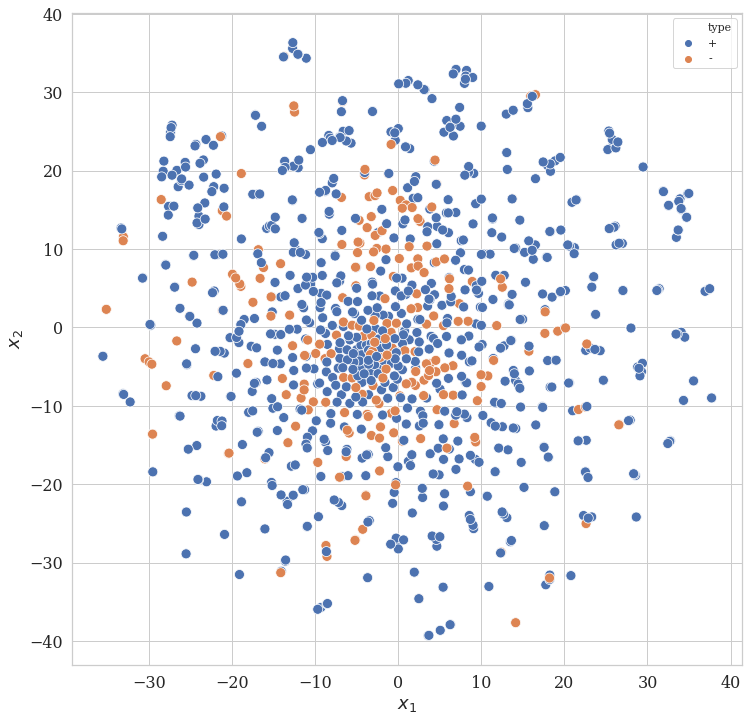

In [121]:
plot_tsne(cleared_test_pairs, vectorized)

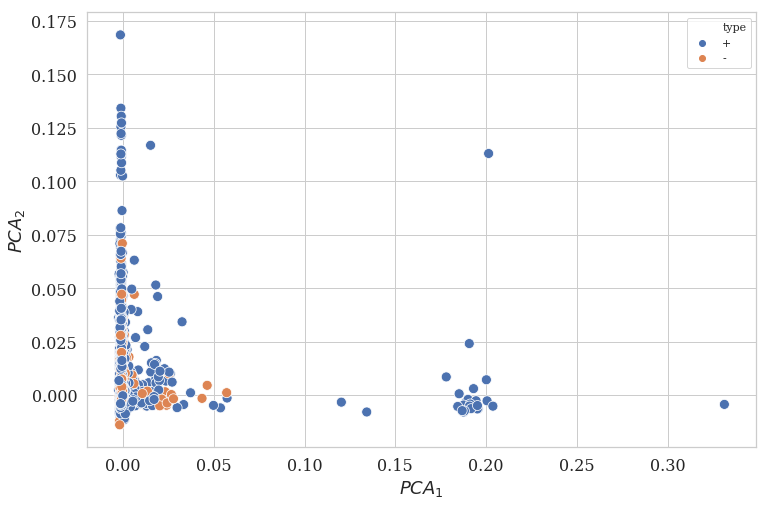

In [122]:
plot_pca(cleared_train_pairs, vectorized)

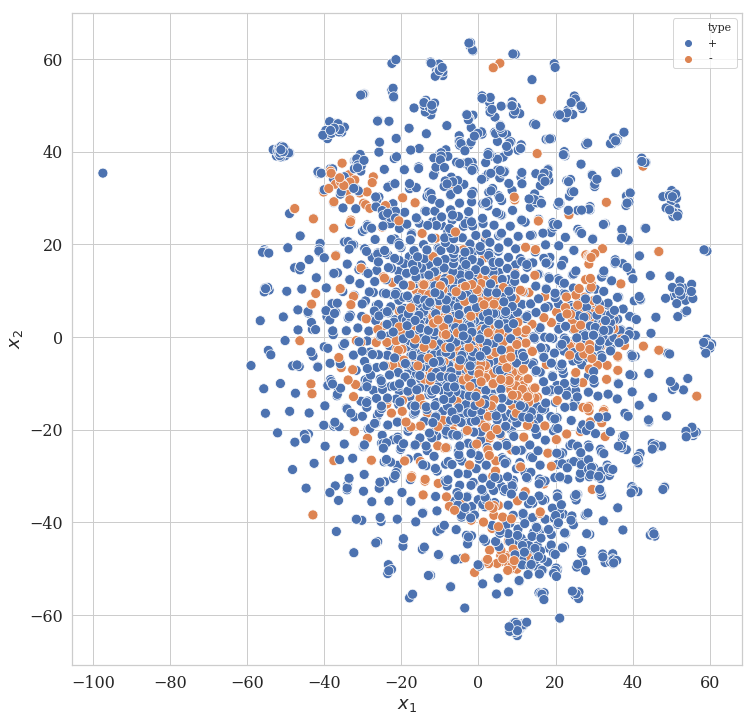

In [123]:
plot_tsne(cleared_train_pairs, vectorized)

In [127]:
tuned_emb = {}
with open('./tuned_emb.json', 'r') as inp:
    tuned_emb = json.load(inp)

In [130]:
whole = cleared_test_pairs + cleared_train_pairs


In [132]:
'endocentric' in vectorized

True

## 2 million words

In [155]:
crawl_emb = {}
with open('crawl_emb.json', 'r') as inp_file:
    crawl_emb = json.load(inp_file)

In [156]:
cleared_pairs = []
for fst, scnd, sign in test:
    if fst in vectorized and scnd in vectorized:
        cleared_pairs.append((fst, scnd, sign))
cleared_pairs = list(set(cleared_pairs))

In [157]:
test_dataset = []
train_dataset = []
for elem in pairs:
    syn = elem['synonymic']
    ant = elem['antonymic']
    if (len(test_dataset) / amount) < 0.23:
        for fst, scnd in syn:
            test_dataset.append((fst, scnd, '+'))
        for fst, scnd in ant:
            test_dataset.append((fst, scnd, '-'))
    else:
        for fst, scnd in syn:
            train_dataset.append((fst, scnd, '+'))
        for fst, scnd in ant:
            train_dataset.append((fst, scnd, '-'))

In [158]:
cleared_test_pairs = list(
    set(
        [
            (f, s, sign) for f, s, sign in test_dataset 
            if (f in crawl_emb) and (s in crawl_emb) and (f != s)
        ]
    )
)
cleared_train_pairs = list(
    set(
        [
            (f, s, sign) for f, s, sign in train_dataset 
            if (f in crawl_emb) and (s in crawl_emb) and (f != s)
        ]
    )
)

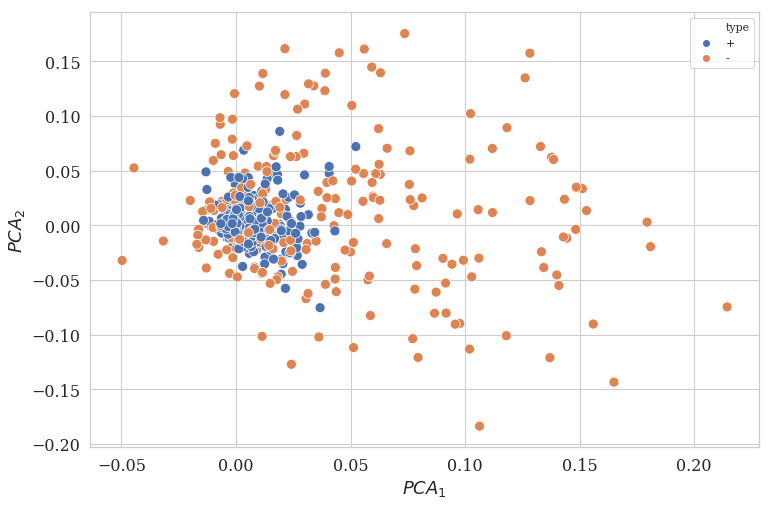

In [159]:
plot_pca(cleared_test_pairs, tuned_emb)

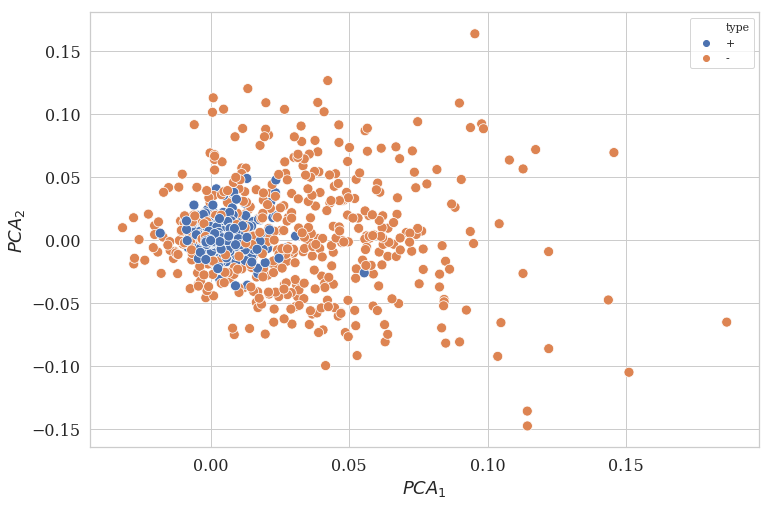

In [161]:
plot_pca(cleared_train_pairs, tuned_emb)

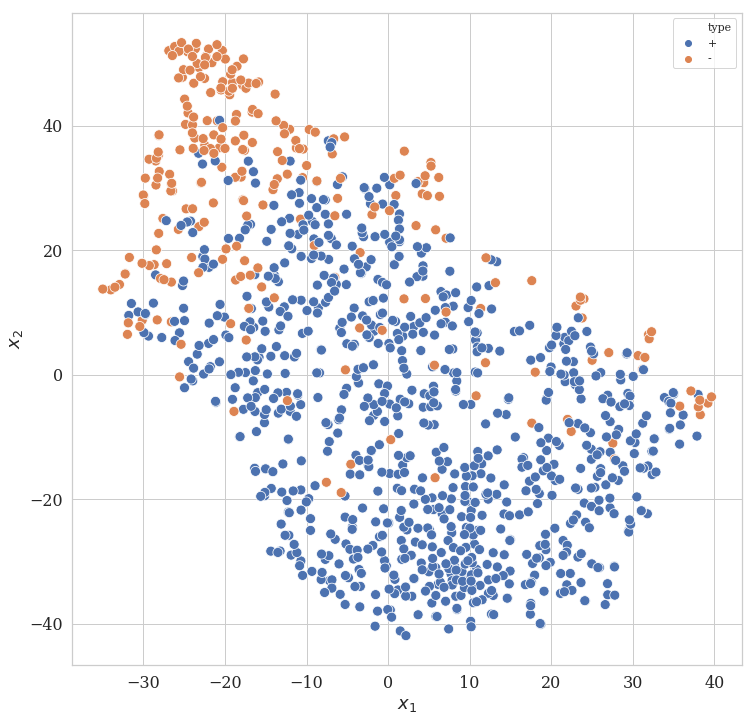

In [162]:
plot_tsne(cleared_test_pairs, tuned_emb)

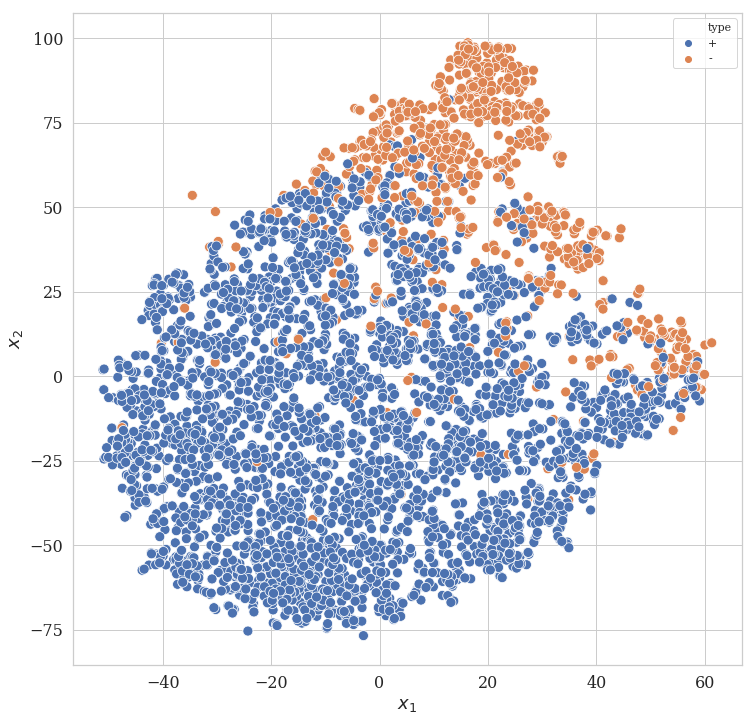

In [163]:
plot_tsne(cleared_test_pairs + cleared_train_pairs, tuned_emb)

In [165]:
with open('train_dataset_clear_2_million.json', 'w') as outfile:
    json.dump(cleared_train_pairs, outfile)